

# Classification of Movie Reviews


This notebook trains classifiers that take a movie review and decide if it is positive or negative. This is an instance of sentence classification, i.e. classifying an input sentence into a predefined set of categories. In turn, it is an instance of text classification. For our movie reviews, texts are one-sentence reviews, and the categories (or labels) are either positive or negative. 

This is a simplified task. In general, these labels are not exclusive: a sentence can be both positive and negative ("I love the script but hate the main actor."), or simply be neutral, which means that a sentence is neither positive nor negative ("I went to the movies."). 

Text classification is a wide area. You'll find plenty of background on it. It is a "simple" task in NLP, also studied in Information Retrieval and used as testbed of machine learning algorithms.

Here is a paper using Convolutional Neural Networks for sentence classification: https://arxiv.org/pdf/1408.5882.pdf .  This notebook uses one of the datasets used in that paper. However, the results are not directly comparable (because the split into train and test is not exactly the same). In any case, we can see that many models get a test accuracy in between 75% and 82%. 


### Setup notebook

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 300)

import numpy as np

import sklearn.metrics
from sklearn.metrics import classification_report
from collections import Counter
import sys
import argparse
from time import time


## Load Movie Reviews with Positive/Negative Label

This section loads the "train" portion of the movie reviews. In addition to the text, there's two more columns:
* `label` is either `positive` or `negative`, indicating the sentiment of the review
* `label_int` is simply 0 for negative reviews and 1 for positive reviews, it will be useful to use with `sklearn`

### Load the training data

In [2]:
mr_train_df = pd.read_csv('../data/movie_reviews_train.csv')

In [3]:
mr_train_df

,text,label,label_int,split
0,the entire movie is so formulaic and forgettable that it's hardly over before it begins to fade from memory .,negative,0,train
1,the whole mess boils down to a transparently hypocritical work that feels as though it's trying to set the women's liberation movement back 20 years .,negative,0,train
2,"smart , provocative and blisteringly funny .",positive,1,train
3,'wouldn't it be nice if all guys got a taste of what it's like on the other side of the bra ? ',negative,0,train
4,"too loud , too long and too frantic by half , die another day suggests that the bond franchise has run into a creative wall that 007 cannot fly over , tunnel under or barrel through .",negative,0,train
...,...,...,...,...
9590,an indispensable peek at the art and the agony of making people laugh .,positive,1,train
9591,"this insufferable movie is meant to make you think about existential suffering . instead , it'll only put you to sleep .",negative,0,train
9592,breen's script is sketchy with actorish notations on the margin of acting .,negative,0,train
9593,"it's plotless , shapeless -- and yet , it must be admitted , not entirely humorless . indeed , the more outrageous bits achieve a shock-you-into-laughter intensity of almost dadaist proportions .",positive,1,train


The labels in this dataset were artificially balanced by the original authors. There's roughly 50% of positive reviews and 50% of negative reviews. The `df.describe` function confirms this (the mean of `label_int` is near 0.5).

In [4]:
mr_train_df.describe()

,label_int
count,9595.000000
mean,0.496821
std,0.500016
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Load the test set

In [6]:
mr_test_df = pd.read_csv('../data/movie_reviews_test.csv')

In [7]:
mr_test_df

,text,label,label_int,split
0,effective but too-tepid biopic,positive,1,test
1,what really surprises about wisegirls is its low-key quality and genuine tenderness .,positive,1,test
2,"ultimately , it ponders the reasons we need stories so much .",positive,1,test
3,offers a breath of the fresh air of true sophistication .,positive,1,test
4,scores a few points for doing what it does with a dedicated and good-hearted professionalism .,positive,1,test
...,...,...,...,...
1062,the hanukkah spirit seems fried in pork .,negative,0,test
1063,doesn't come close to justifying the hype that surrounded its debut at the sundance film festival two years ago .,negative,0,test
1064,"the film didn't move me one way or the other , but it was an honest effort and if you want to see a flick about telemarketers this one will due .",negative,0,test
1065,as saccharine as it is disposable .,negative,0,test


We now check that the test data has the same distribution of labels. 

It is important to note that here we run a check of our files. In real experimental work, it is very important not to gather statistics
about the test data: measuring the distribution of labels on the test is cheating. This is because machine learning _is about_ inducing the
true distribution of test labels using separate data to develop the model. 


In [8]:
mr_test_df.describe()

,label_int
count,1067.000000
mean,0.528585
std,0.499416
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


# Evaluation

This section uses the `sklearn` function to evaluate classifiers. There are several metrics of interest. Let's first focus on accuracy, i.e. the portion of correct predictions in the test. Later we will see precision and recall. The `sklearn.metrics.classification_report` gets as input the list of correct labels (as integers) and the list of predictions, and computes the metrics. 

To try it, let's define two dummy classifiers, one that always predicts "positive" (i.e. 1) and another that always predicts "negative" (i.e. 0).

In [9]:
def dummy_positive(text):
    return 1

def dummy_negative(text):
    return 0

Let's eval the dummy positive (and check it gives the dataset mean of `label_int`)

In [10]:
print('Baseline: predict always positive')
print(classification_report(mr_test_df.label_int, 
                            [dummy_positive(text) for text in mr_test_df.text],
                            target_names=['negative', 'positive'], 
                            zero_division=0))

Baseline: predict always positive
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       503
    positive       0.53      1.00      0.69       564

    accuracy                           0.53      1067
   macro avg       0.26      0.50      0.35      1067
weighted avg       0.28      0.53      0.37      1067



Now let's eval the dummy negative classifier (which should have accuracy equal to 1 minus the mean of label_int):

In [11]:
print('Baseline: predict always negative')
print(classification_report(mr_test_df.label_int, 
                           [dummy_negative(text) for text in mr_test_df.text],
                            target_names=['negative', 'positive'], 
                            zero_division=0))

Baseline: predict always negative
              precision    recall  f1-score   support

    negative       0.47      1.00      0.64       503
    positive       0.00      0.00      0.00       564

    accuracy                           0.47      1067
   macro avg       0.24      0.50      0.32      1067
weighted avg       0.22      0.47      0.30      1067



# Bag-of-words classifiers using Scikit-Learn

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

def make_sklearn_naive_bayes():
    classifier = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])
    return classifier

def make_sklearn_sgd():
    classifier = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                              alpha=1e-3, random_state=42,
                              max_iter=5, tol=None)),
        ])
    return classifier


## Naive Bayes Model

Let's start training a Naive Bayes model:

In [13]:
# movie reviews naive bayes model
mr_naivebayes = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])
mr_naivebayes.fit(mr_train_df.text, mr_train_df.label_int)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

We can now do predictions. The `predict` function receives a list of texts, and computes a label (integer) for each input text:

In [14]:
input_texts = ['the story is horrible', 
               'the story is not great',
               ' awesome!', 
               'i liked the movie', 
               'i enjoyed it a lot', 
               "I didn't like it at all"]
predictions = mr_naivebayes.predict(input_texts)
for text, pred_int in zip(input_texts, predictions):
    print('Text: {:40s}  prediction_int: {}   prediction: {}'.format(text, pred_int, 'positive' if pred_int==1 else 'negative'))

Text: the story is horrible                     prediction_int: 0   prediction: negative
Text: the story is not great                    prediction_int: 1   prediction: positive
Text:  awesome!                                 prediction_int: 1   prediction: positive
Text: i liked the movie                         prediction_int: 1   prediction: positive
Text: i enjoyed it a lot                        prediction_int: 1   prediction: positive
Text: I didn't like it at all                   prediction_int: 0   prediction: negative


Let's make predictions on the test set and check how many of them are correct (simple accuracy calculation):

In [15]:
mr_test_naivebayes = mr_naivebayes.predict(mr_test_df.text)

In [16]:
diff = mr_test_naivebayes == mr_test_df.label_int

In [17]:
Counter(diff)[True]/len(diff)

0.781630740393627

Evaluation using `sklearn` metrics:

In [18]:
print(classification_report(mr_test_df.label_int, 
                            mr_test_naivebayes, 
                            target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.76      0.78      0.77       503
    positive       0.80      0.78      0.79       564

    accuracy                           0.78      1067
   macro avg       0.78      0.78      0.78      1067
weighted avg       0.78      0.78      0.78      1067



## SGD classifiers

Let's now train an SGD classifier using the Hinge loss. 

The alpha parameter controls the regularization: lower values of alpha mean that the model is less regularized. It's worth trying several values of alpha, and see how the results change. Try it by orders of magnitude: 0.1, 0.01, 0.001, ..., 1e-12

In [19]:
# Movie Reviews SGD classifier
mr_sgd = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer(use_idf=True)),
        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                              alpha=1e-5, random_state=42,
                              max_iter=100, tol=None)),
        ])
mr_sgd.fit(mr_train_df.text, mr_train_df.label_int)

# eval
print(classification_report(mr_test_df.label_int, 
                            mr_sgd.predict(mr_test_df.text), 
                            target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.74      0.76      0.75       503
    positive       0.78      0.77      0.77       564

    accuracy                           0.76      1067
   macro avg       0.76      0.76      0.76      1067
weighted avg       0.76      0.76      0.76      1067



### Inspect weights of the SGD model

We will now look at what the SGD model learned. The following funtion "extracts" an array of the learned parameters of the model. Each parameter is a tuple `(word, weight)`. The parameters are sorted by its weight. 

In [20]:
def sort_feature_weights(sk_pipe, fkey='vect', wkey='clf'):
    F = sk_pipe[fkey].get_feature_names_out()
    W = sk_pipe[wkey].coef_[0]
    return sorted(zip(F, W), key=lambda fw: fw[1])

We will list the n=20 words with most positive/negative weights:

In [21]:
mr_sgd_weights = sort_feature_weights(mr_sgd)

In [22]:
n=20
print('words most correlated with negative:')
mr_sgd_weights[:n]

words most correlated with negative:


[('unless', -5.174220295766207),
 ('wasn', -4.534456220992281),
 ('boldface', -4.414331942151835),
 ('flounders', -4.231376877158802),
 ('choppy', -4.053364380278769),
 ('pie', -3.9540375889065498),
 ('routine', -3.9326019277673345),
 ('mindless', -3.9177859183940202),
 ('benigni', -3.8614558325045545),
 ('bore', -3.833627528455997),
 ('conscientious', -3.8003476141605605),
 ('fishing', -3.7101439726858456),
 ('worst', -3.706579507951898),
 ('stupid', -3.687113895359782),
 ('eyre', -3.681220544220409),
 ('fails', -3.6665962191953865),
 ('poorly', -3.663973372343812),
 ('badly', -3.618171978602017),
 ('superficial', -3.6158750649068603),
 ('laughable', -3.5829910560447455)]

In [23]:
print('words most correlated with positive:')
mr_sgd_weights[-n:]

words most correlated with positive:


[('marching', 3.6253398297753674),
 ('glorious', 3.6789064707746797),
 ('conscience', 3.6992191236368503),
 ('count', 3.71738091906613),
 ('marvel', 3.7224536363623435),
 ('accurate', 3.7353839524116457),
 ('unexpected', 3.756394750413514),
 ('frailty', 3.7785329948196975),
 ('smarter', 3.7986128472505185),
 ('astounds', 3.8293024903841055),
 ('ingenious', 3.883784639804631),
 ('weirder', 3.8984195639886456),
 ('grown', 3.960459031849739),
 ('moodiness', 3.9731458202187864),
 ('provides', 4.0087893658843265),
 ('apocalypse', 4.3145944004051175),
 ('caved', 4.404622794910473),
 ('taut', 4.433143482033556),
 ('engrossing', 4.715143819649762),
 ('liberating', 5.667985777757326)]

Now let's see the predictions on hand-picked textual examples ... To fully understand the prediction score, we need to consider that the model has a bias (intercept) term too. 

In [24]:
mr_sgd_bias = mr_sgd['clf'].intercept_[0]
mr_sgd_bias

-0.2639657872619253

In [25]:
def prediction_score_breakdown(sk_model, text):
    """Computes the prediction score for a text, breaking down into the individual scores for each word of the text."""
    X = [text]
    for step_name, model in sk_model.steps[:-1]:
        X = model.transform(X)
    nzrows, nzcolumns = X.nonzero()
    
    F = sk_model.steps[0][1].get_feature_names_out()
    W = sk_model.steps[-1][1].coef_[0]
    bias = sk_model.steps[-1][1].intercept_[0]
    total_score = bias
    print('prediction_score={:.3f}   bias={}'.format(total_score, bias))
    for i,j in zip(nzrows, nzcolumns):
        f = F[j]
        v = X[i,j]
        w = W[j]
        s = w*v
        total_score += s
        print('prediction_score={:.3f}   fdim={:5d}, fword="{:s}", value={:.4f}, weight={:.4f}, score={:.4f}'.format(total_score, j, f, v, w, s))
    return total_score

In [26]:
mr_sgd.decision_function(['marvel marching glorious'])

array([6.09841544])

In [27]:
prediction_score_breakdown(mr_sgd, '')

prediction_score=-0.264   bias=-0.2639657872619253


-0.2639657872619253

In [28]:
prediction_score_breakdown(mr_sgd, 'glorious!')

prediction_score=-0.264   bias=-0.2639657872619253
prediction_score=3.415   fdim= 6616, fword="glorious", value=1.0000, weight=3.6789, score=3.6789


3.4149406835127545

In [29]:
prediction_score_breakdown(mr_sgd, 'good script but bad actors')

prediction_score=-0.264   bias=-0.2639657872619253
prediction_score=-0.076   fdim=  325, fword="actors", value=0.5376, weight=0.3488, score=0.1875
prediction_score=-0.928   fdim= 1239, fword="bad", value=0.4641, weight=-1.8350, score=-0.8516
prediction_score=-1.040   fdim= 2152, fword="but", value=0.2761, weight=-0.4063, score=-0.1122
prediction_score=-0.022   fdim= 6666, fword="good", value=0.4064, weight=2.5060, score=1.0184
prediction_score=-0.847   fdim=13493, fword="script", value=0.5042, weight=-1.6363, score=-0.8250


-0.8468562666086891

In [30]:
prediction_score_breakdown(mr_sgd, 'bad script but good actors')

prediction_score=-0.264   bias=-0.2639657872619253
prediction_score=-0.076   fdim=  325, fword="actors", value=0.5376, weight=0.3488, score=0.1875
prediction_score=-0.928   fdim= 1239, fword="bad", value=0.4641, weight=-1.8350, score=-0.8516
prediction_score=-1.040   fdim= 2152, fword="but", value=0.2761, weight=-0.4063, score=-0.1122
prediction_score=-0.022   fdim= 6666, fword="good", value=0.4064, weight=2.5060, score=1.0184
prediction_score=-0.847   fdim=13493, fword="script", value=0.5042, weight=-1.6363, score=-0.8250


-0.8468562666086891

---
# Bag-of-ngrams (and Grid-Search in sklearn)

A simple bag-of-words model has clearly many limitations. It completely ignores word order, and can shuffle meaning. Under a pure bag-of-words, "I love the script, I hate the music" is equivalent to "I hate the script, I love the music.". 

A simple generalization of words are n-grams. If a sentence is a sequence of words, then an n-gram is a subsequence of size n. As such, a word is a 1-gram (unigram), while two consecutive words are a 2-gram (bigram). 

This is very popular in NLP and information retrieval. It is one of the foundations of statistical NLP!!! 

Let's play with it. We first define a convenience function to create an `sklearn` text analyzer, that extracts n-grams, up to a given n. The resulting representation is a bag-of-ngrams. 

In [31]:
def make_sklearn_analyzer(n=1):
    """Creates a text analyzer from sklearn that extracts n-grams."""
    vect = CountVectorizer(stop_words=[], ngram_range=(1,n))
    analyzer = vect.build_analyzer()
    return analyzer

In [32]:
unigram_analyzer = make_sklearn_analyzer(1)

In [33]:
sentence = "I love the script, I hate the music"
unigram_analyzer(sentence)

['love', 'the', 'script', 'hate', 'the', 'music']

In [34]:
sentence = "I hate the script, I love the music"
unigram_analyzer(sentence)

['hate', 'the', 'script', 'love', 'the', 'music']

In [35]:
bigram_analyzer = make_sklearn_analyzer(2)
bigram_analyzer(sentence)

['hate',
 'the',
 'script',
 'love',
 'the',
 'music',
 'hate the',
 'the script',
 'script love',
 'love the',
 'the music']

In [36]:
trigram_analyzer = make_sklearn_analyzer(3)
trigram_analyzer(sentence)

['hate',
 'the',
 'script',
 'love',
 'the',
 'music',
 'hate the',
 'the script',
 'script love',
 'love the',
 'the music',
 'hate the script',
 'the script love',
 'script love the',
 'love the music']

## Grid-search in `sklearn`


In [37]:
from sklearn.model_selection import GridSearchCV

def crossvalidation_report_df(grid_cv): 
    """Convenience  function. 
    
    Creates a simple dataframe that reports the results of a 
    cros-validation experiment. The input grid_cv must be fit. 
    
    Returns a dataframe, sorted by rank of experiment. 
    """
    # pick columns that define each experiment (start with param)
    # and the columns that report mean_test and rank_test results
    cols = [c for c in grid_cv.cv_results_ if (c.startswith('param') or 
                                               c in ['mean_test_score', 'rank_test_score'])]

    # sort original df by rank, and select columns
    return pd.DataFrame(grid_cv.cv_results_).sort_values(by='rank_test_score')[cols]


Let's now define one grid-search for SGD:

In [38]:
# this defines the base sklearn pipeline we want tot tune
sgd_grid_estimator = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=100, tol=None)),
])

# this defines the configurations
sgd_grid_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'clf__alpha': (1e-3, 1e-6, 1e-9, 1e-12)
}

# we create the grid
sgd_grid= GridSearchCV(sgd_grid_estimator, sgd_grid_parameters, verbose=1)

*Attention* the cell below will start grid search, which trains many models. It can take some time ... be patient, or reduce the combinations. 

In [39]:
sgd_grid.fit(mr_train_df.text, mr_train_df.label_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        SGDClassifier(max_iter=100,
                                                      random_state=42,
                                                      tol=None))]),
             param_grid={'clf__alpha': (0.001, 1e-06, 1e-09, 1e-12),
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

In [40]:
crossvalidation_report_df(sgd_grid)

,param_clf__alpha,param_vect__ngram_range,params,mean_test_score,rank_test_score
4,1.000000e-06,"(1, 2)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1, 2)}",0.773111,1
5,1.000000e-06,"(1, 3)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}",0.770401,2
8,1.000000e-09,"(1, 3)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1, 3)}",0.755185,3
7,1.000000e-09,"(1, 2)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1, 2)}",0.755081,4
10,1.000000e-12,"(1, 2)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1, 2)}",0.754247,5
11,1.000000e-12,"(1, 3)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1, 3)}",0.751016,6
6,1.000000e-09,"(1, 1)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1, 1)}",0.735591,7
3,1.000000e-06,"(1, 1)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1, 1)}",0.733507,8
9,1.000000e-12,"(1, 1)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1, 1)}",0.733403,9
0,1.000000e-03,"(1, 1)","{'clf__alpha': 0.001, 'vect__ngram_range': (1, 1)}",0.726733,10


In [41]:
sgd_best = sgd_grid.best_estimator_
print('BEST PARAMS:', sgd_grid.best_params_)
# eval
print(classification_report(mr_test_df.label_int, 
                            sgd_best.predict(mr_test_df.text), 
                            target_names=['negative', 'positive']))

BEST PARAMS: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 2)}
              precision    recall  f1-score   support

    negative       0.80      0.79      0.79       503
    positive       0.81      0.82      0.82       564

    accuracy                           0.81      1067
   macro avg       0.80      0.80      0.80      1067
weighted avg       0.80      0.81      0.80      1067



In [42]:
sgd_best_weights = sort_feature_weights(sgd_best)

In [43]:
sgd_best_weights = sorted(sgd_best_weights, key=lambda fw: fw[1], reverse=True)

In [44]:
print('Model weights associated with positive reviews')
sgd_best_weights[:50]

Model weights associated with positive reviews


[('still', 3.7400963405321797),
 ('cinema', 3.6505771877913635),
 ('works', 3.486407496281639),
 ('beautiful', 3.340373551322183),
 ('solid', 3.2654964163731997),
 ('enjoyable', 3.231271598317809),
 ('and', 3.13840199399024),
 ('funny', 3.097583408112965),
 ('unexpected', 3.0756243905833607),
 ('entertaining', 3.0388488684385977),
 ('powerful', 3.0310451255398365),
 ('wonderful', 2.755236206884593),
 ('honest', 2.747074885887034),
 ('fun', 2.746002319658066),
 ('world', 2.7132857354154445),
 ('warm', 2.6909739770486394),
 ('hilarious', 2.6757404051761666),
 ('glorious', 2.6629359820420597),
 ('heart', 2.6439902559341997),
 ('refreshing', 2.5902746930342855),
 ('delivers', 2.5876519425596096),
 ('human', 2.5634164612763484),
 ('remarkable', 2.532848746783074),
 ('treat', 2.5126389139003296),
 ('delightful', 2.501287149013983),
 ('with', 2.4918319971083065),
 ('beautifully', 2.4565293520733484),
 ('unique', 2.4532179978438955),
 ('provides', 2.4493178929629256),
 ('mesmerizing', 2.448059

In [45]:
print('Model weights associated with negative reviews')
sgd_best_weights[-50:]

Model weights associated with negative reviews


[('an action', -2.17167335556074),
 ('out of', -2.195339841885952),
 ('suffers', -2.20799606099705),
 ('cartoon', -2.229898184661163),
 ('stale', -2.250471062152165),
 ('ill', -2.251795482238586),
 ('superficial', -2.262962863599115),
 ('unimaginative', -2.265947747287026),
 ('for movie', -2.2969557601492347),
 ('dreary', -2.311856778778193),
 ('video', -2.32086830190218),
 ('seagal', -2.330044204028073),
 ('to one', -2.35897924090565),
 ('bland', -2.3809052946878078),
 ('lame', -2.415737660977717),
 ('disappointment', -2.422366530090093),
 ('incoherent', -2.4621134875392516),
 ('john', -2.5121980187496193),
 ('plodding', -2.534879066055758),
 ('unfunny', -2.552586778859063),
 ('mediocre', -2.5623583255315223),
 ('then', -2.575409944997356),
 ('feels', -2.6090055893820043),
 ('barely', -2.6403657879476152),
 ('mildly', -2.654315725890339),
 ('thin', -2.655794388267386),
 ('junk', -2.683132978523542),
 ('the problem', -2.6882280892584465),
 ('no', -2.6921228276460534),
 ('pretentious', 

In [46]:
# convenience function: given a feature ngram, returns the number of "grams"
# i.e. 1 for unigrams, 2 for bigrams, ....
# simply counts the number of elements separated by space (this is how sklearn encodes unigrams)
def ngram_order(f):
    """Returns the ngram order of a feature. """
    return len(f.split())

In [47]:
print('Bigram weights associated with positive reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==2][:20]

Bigram weights associated with positive reviews


[('never fails', 2.421654710232767),
 ('never once', 2.325947158454947),
 ('once predictable', 2.325947158454947),
 ('is more', 2.310968549462901),
 ('ever made', 2.25305862380259),
 ('better than', 2.199851565938953),
 ('it is', 2.18959488744057),
 ('but that', 2.1753026417629346),
 ('what makes', 2.1465030243795518),
 ('not only', 2.115111336482161),
 ('the best', 2.0777014860200054),
 ('up for', 2.064731074877175),
 ('may not', 2.0646655396326787),
 ('weird rewarding', 2.0358547574927757),
 ('never feels', 2.0282079456568),
 ('make it', 2.0206240674610148),
 ('but it', 1.974511157341453),
 ('for its', 1.9630177498857377),
 ('to resist', 1.9338122772751158),
 ('bad journey', 1.9130748822367378)]

In [48]:
print('Bigram weights associated with negative reviews')
[fw for fw in sgd_best_weights if len(fw[0].split())==2][-20:]

Bigram weights associated with negative reviews


[('enough for', -1.8693035793360577),
 ('case of', -1.9056559238005584),
 ('it exactly', -1.9058241605858),
 ('lacks the', -1.9121895251720191),
 ('first film', -1.9596079611178208),
 ('should have', -1.9687219250792547),
 ('at best', -1.9964359053054412),
 ('least moore', -2.027041064654314),
 ('work but', -2.0399780292395224),
 ('fact that', -2.0642072908849554),
 ('plays like', -2.0681409027681465),
 ('my own', -2.0949191323289402),
 ('you see', -2.127080873324575),
 ('an action', -2.17167335556074),
 ('out of', -2.195339841885952),
 ('for movie', -2.2969557601492347),
 ('to one', -2.35897924090565),
 ('the problem', -2.6882280892584465),
 ('has all', -2.8590256229049587),
 ('the worst', -3.060903547545085)]

In [49]:
sgd_best.decision_function(['this marvel movie is not memorable at all'])

array([0.90613591])

In [50]:
prediction_score_breakdown(sgd_best, 'this marvel movie is not memorable at all')

prediction_score=-0.182   bias=-0.1823518644722022
prediction_score=-0.346   fdim= 2779, fword="all", value=0.1971, weight=-0.8289, score=-0.1634
prediction_score=-0.458   fdim=10054, fword="at", value=0.1952, weight=-0.5751, score=-0.1123
prediction_score=-0.699   fdim=10069, fword="at all", value=0.3673, weight=-0.6560, score=-0.2409
prediction_score=-0.602   fdim=50770, fword="is", value=0.1186, weight=0.8184, score=0.0971
prediction_score=-0.763   fdim=51432, fword="is not", value=0.2984, weight=-0.5387, score=-0.1607
prediction_score=0.069   fdim=60448, fword="marvel", value=0.4082, weight=2.0376, score=0.8317
prediction_score=0.790   fdim=61346, fword="memorable", value=0.3417, weight=2.1092, score=0.7208
prediction_score=0.637   fdim=63855, fword="movie", value=0.1597, weight=-0.9552, score=-0.1526
prediction_score=0.578   fdim=64033, fword="movie is", value=0.2720, weight=-0.2173, score=-0.0591
prediction_score=0.354   fdim=66825, fword="not", value=0.1882, weight=-1.1934, scor

0.9061359136690519

In [51]:
prediction_score_breakdown(sgd_best, 'I did not enjoy the movie')

prediction_score=-0.182   bias=-0.1823518644722022
prediction_score=-0.282   fdim=26395, fword="did", value=0.3925, weight=-0.2549, score=-0.1001
prediction_score=-0.233   fdim=26411, fword="did not", value=0.5407, weight=0.0917, score=0.0496
prediction_score=0.216   fdim=31002, fword="enjoy", value=0.3730, weight=1.2036, score=0.4489
prediction_score=0.117   fdim=31019, fword="enjoy the", value=0.5102, weight=-0.1932, score=-0.0986
prediction_score=-0.058   fdim=63855, fword="movie", value=0.1835, weight=-0.9552, score=-0.1753
prediction_score=-0.316   fdim=66825, fword="not", value=0.2162, weight=-1.1934, score=-0.2580
prediction_score=-0.302   fdim=96572, fword="the", value=0.0925, weight=0.1456, score=0.0135
prediction_score=-0.727   fdim=98305, fword="the movie", value=0.2555, weight=-1.6639, score=-0.4250


-0.7273216140615937

In [52]:
prediction_score_breakdown(sgd_best, 'I did not enjoy the movie with still works at the cinema it is it is it bla bla is')

prediction_score=-0.182   bias=-0.1823518644722022
prediction_score=-0.251   fdim=10054, fword="at", value=0.1185, weight=-0.5751, score=-0.0682
prediction_score=-0.010   fdim=10225, fword="at the", value=0.1649, weight=1.4575, score=0.2404
prediction_score=0.650   fdim=19570, fword="cinema", value=0.1808, weight=3.6506, score=0.6600
prediction_score=0.597   fdim=26395, fword="did", value=0.2075, weight=-0.2549, score=-0.0529
prediction_score=0.623   fdim=26411, fword="did not", value=0.2858, weight=0.0917, score=0.0262
prediction_score=0.860   fdim=31002, fword="enjoy", value=0.1971, weight=1.2036, score=0.2373
prediction_score=0.808   fdim=31019, fword="enjoy the", value=0.2697, weight=-0.1932, score=-0.0521
prediction_score=0.985   fdim=50770, fword="is", value=0.2160, weight=0.8184, score=0.1768
prediction_score=0.900   fdim=51289, fword="is it", value=0.4355, weight=-0.1953, score=-0.0851
prediction_score=1.009   fdim=52030, fword="it", value=0.2215, weight=0.4933, score=0.1093
pr

3.1918144987220827

---
# Precision and recall

This section looks at precision and recall metrics. They are an alternative to accuracy, and very often they are much more difficult. Accuracy only cares about right or wrong, but there is more. 

Consider the label "positive". There are truly positive examples, and if a classifier predicts "negative" for a positive example, it is making a "false negative" mistake, because the example is not negative. Now consider a truly negative example, if our classifier predicts "positive" it will make a "false positive" mistake. False positives and false negatives are all mistakes, and normal accuracy does not distinguish. Precision and recall specifically look at each of the sides of mistakes. 

Precision looks at "false positive" mistakes. Specifically, it is the fraction of true positives out of the total number of examples where a classifier predicts "positive". A precision of 100% means that every time a classifier says "positive" the example is truly positive. Lower precision means that there are false positives among our predictions. 

Recall looks at "false negative" mistakes. Out of all truly positive examples, it is the fraction that is correctly labeled as "positive". A recall of 100% means that our classifier will identify all truly positive examples in the data, probably at the expense of making precision mistakes. An extreme case is a dumb classifier that always predicts "positive", it will have recall at 100%, but precision will be the fraction of true positives in the test data.

In [53]:
mr_test_df['score_sgd_best'] = sgd_best.decision_function(mr_test_df.text)

and let's visualize the data sorted by the prediction score ...

In [54]:
mr_test_df.sort_values(by='score_sgd_best', ascending=True, inplace=True)

In [55]:
mr_test_df.head(5)

,text,label,label_int,split,score_sgd_best
595,bad company . bad movie . just plain bad .,negative,0,test,-3.456775
573,"the plot is nothing but boilerplate clichs from start to finish , and the script assumes that not only would subtlety be lost on the target audience , but that it's also too stupid to realize that they've already seen this exact same movie a hundred times",negative,0,test,-3.192490
741,generic thriller junk . teens only .,negative,0,test,-3.131216
1037,it's supposed to be post-feminist breezy but ends up as tedious as the chatter of parrots raised on oprah .,negative,0,test,-2.994342
1045,"a tired , predictable , bordering on offensive , waste of time , money and celluloid .",negative,0,test,-2.987306


In [56]:
mr_test_df.tail(5)

,text,label,label_int,split,score_sgd_best
367,scott delivers a terrific performance in this fascinating portrait of a modern lothario .,positive,1,test,3.139697
425,"a wonderful , ghastly film .",positive,1,test,3.149427
170,"an entertaining , colorful , action-filled crime story with an intimate heart .",positive,1,test,3.193826
480,jones has delivered a solidly entertaining and moving family drama .,positive,1,test,3.222283
23,"[a] rare , beautiful film .",positive,1,test,3.391656


In [57]:
mr_test_df[200:250]

,text,label,label_int,split,score_sgd_best
1021,"none of this has the suavity or classical familiarity of bond , but much of it is good for a laugh . the problem with "" xxx "" is that its own action isn't very effective .",negative,0,test,-1.001593
819,"no worse than a lot of the crap we've been offered this summer , and slightly better than men in black 2 as far as slapdash extraterrestrial comedies go .",negative,0,test,-1.000973
774,"that is essentially what's missing from blackboards -- the sense of something bigger , some ultimate point .",negative,0,test,-0.982993
1020,"slow , silly and unintentionally hilarious .",negative,0,test,-0.978434
1023,predictably melodramatic .,negative,0,test,-0.969477
590,the plot plummets into a comedy graveyard before janice comes racing to the rescue in the final reel .,negative,0,test,-0.966050
1002,hollywood's answer to an air ball .,negative,0,test,-0.962204
783,"like so many other allegedly scary movies , it gets so tangled up in the twist that it chokes the energy right out of the very audience it seeks to frighten .",negative,0,test,-0.943751
1031,burns' fifth beer-soaked film feels in almost every possible way -- from the writing and direction to the soggy performances -- tossed off .,negative,0,test,-0.943511
804,a less-than-thrilling thriller .,negative,0,test,-0.939905


By varying the threshold of the classifier we can alter the precision and recall of a trained model. 

In [58]:
# the scores are computed once the model is fit
test_scores = sgd_best.decision_function(mr_test_df.text)

# and afterwards we can alter the threshold
for threshold in [-2, -1, 0, 1, 2]:
    print("Metrics with threshold={}".format(threshold))
    print(classification_report(mr_test_df.label_int, 
                               [1 if s>threshold else 0 for s in test_scores], 
                               target_names=['negative', 'positive']))
    print()

Metrics with threshold=-2
              precision    recall  f1-score   support

    negative       1.00      0.11      0.20       503
    positive       0.56      1.00      0.72       564

    accuracy                           0.58      1067
   macro avg       0.78      0.55      0.46      1067
weighted avg       0.77      0.58      0.47      1067


Metrics with threshold=-1
              precision    recall  f1-score   support

    negative       0.93      0.37      0.53       503
    positive       0.64      0.98      0.77       564

    accuracy                           0.69      1067
   macro avg       0.78      0.67      0.65      1067
weighted avg       0.77      0.69      0.66      1067


Metrics with threshold=0
              precision    recall  f1-score   support

    negative       0.80      0.79      0.79       503
    positive       0.81      0.82      0.82       564

    accuracy                           0.81      1067
   macro avg       0.80      0.80      0.80      

`sklearn` has a nice function that computes a curve of precision-recall-threshold values ...

In [59]:
pr_sgd_best = sklearn.metrics.precision_recall_curve(mr_test_df.label_int, 
                                                     sgd_best.decision_function(mr_test_df.text), 
                                                     pos_label=1)

In [60]:
pr_sgd_uni = sklearn.metrics.precision_recall_curve(mr_test_df.label_int, 
                                                    mr_sgd.decision_function(mr_test_df.text), 
                                                    pos_label=1)

In [61]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

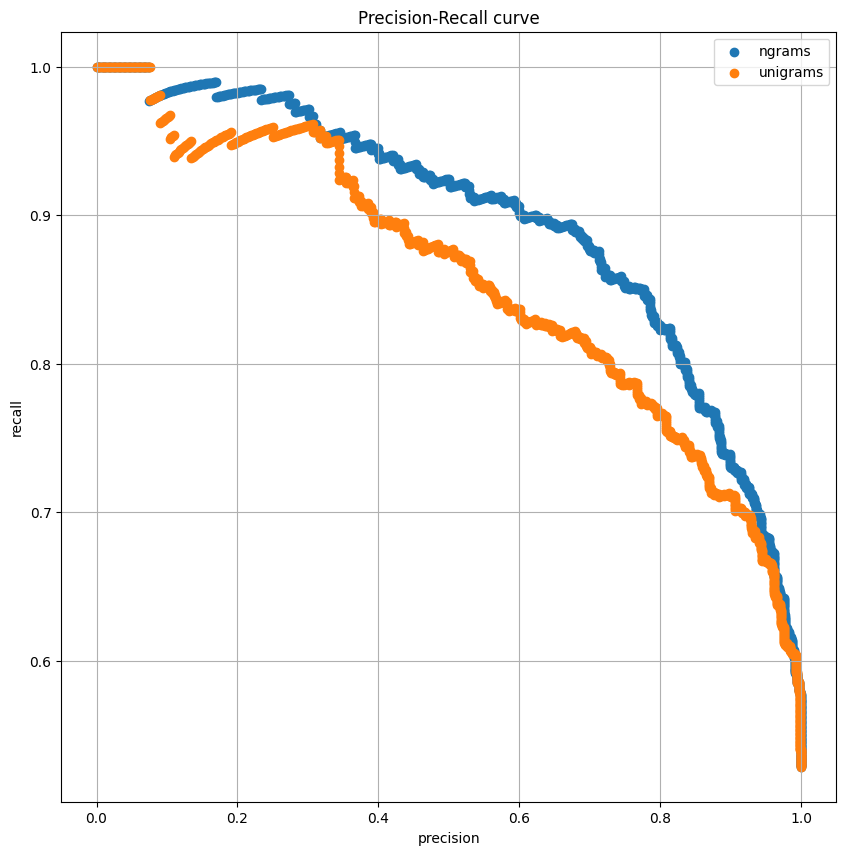

In [62]:
plt.figure(figsize=(10,10))
plt.title('Precision-Recall curve')
plt.xlabel('precision')
plt.ylabel('recall')
plt.scatter(y=pr_sgd_best[0], x=pr_sgd_best[1], label='ngrams')
plt.scatter(y=pr_sgd_uni[0], x=pr_sgd_uni[1], label='unigrams')
plt.grid(True)
plt.legend()

Load the "ag_news_train.csv" and "ag_news_test.csv" files on the NLP Lab Folder. Each text in the collection is labeled with one of four classes: "science", "sports", "world", "business". There's roughly 110K training examples and 10K test examples.



In [5]:
import pandas as pd
import numpy as np
import sys
from time import time
import matplotlib

# Determine if running in IPython/Jupyter
is_jupyter = False
try:
    # This will raise an exception if not in IPython
    ipy_str = str(type(get_ipython()))
    if 'zmqshell' in ipy_str:
        is_jupyter = True
        # In a Jupyter notebook, use interactive matplotlib
        import matplotlib.pyplot as plt
    else:
        # Use non-interactive backend for IPython but not notebook
        matplotlib.use('Agg')
        import matplotlib.pyplot as plt
except:
    # Use non-interactive backend for standard python
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score

# Configure pandas display options
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 300)

# Load datasets
print("Loading datasets...")
agnews_train_df = pd.read_csv('../data/agnews_train.csv')
agnews_test_df = pd.read_csv('../data/agnews_test.csv')

print(f"Training set shape: {agnews_train_df.shape}")
print(f"Test set shape: {agnews_test_df.shape}")

# Check a few samples
print("\nSample training data:")
print(agnews_train_df.head())

# Verify science_int column exists
print("\nVerifying science_int column...")
if 'science_int' not in agnews_train_df.columns:
    print("Error: science_int column not found!")
else:
    print(f"Science class distribution in training set: {agnews_train_df['science_int'].value_counts()}")



Loading datasets...
Training set shape: (109999, 7)
Test set shape: (10000, 7)

Sample training data:
                                                                                                                                                                                                                                           text     label  label_int  science_int  sports_int  world_int  \
0                           John Souza, a volunteer with the Boone County chapter of the American Red Cross, is the second Columbia resident to join efforts to assist people who were affected by Tropical Storm Bonnie and Hurricane Charley.  Business          3            0           0          0   
1        Spain needs only to beat an under-strength French team to secure its place in the Davis Cup tennis final, while Britain looks to the experience of Tim Henman and Greg Rusedski in its World Group play-off with Austria this weekend.    Sports          1            0           1          0  

In [7]:
# Define helper function for cross-validation reporting
def crossvalidation_report_df(grid_cv):
    """Creates a dataframe that reports the results of a cross-validation experiment.
    
    Args:
        grid_cv: A fitted GridSearchCV object
        
    Returns:
        A pandas DataFrame, sorted by rank of experiment
    """
    # Select columns that define each experiment and results
    cols = [c for c in grid_cv.cv_results_ if (c.startswith('param') or 
                                               c in ['mean_test_score', 'rank_test_score'])]

    # Sort by rank and select columns
    return pd.DataFrame(grid_cv.cv_results_).sort_values(by='rank_test_score')[cols]

# Define function to train SGD classifier with cross-validation
def train_sgd_classifier(X_train, y_train, cv=5):
    """Trains an SGD classifier with cross-validation to find optimal hyperparameters.
    
    Args:
        X_train: Training features (text)
        y_train: Training labels
        cv: Number of cross-validation folds
        
    Returns:
        The best model after cross-validation
    """
    print(f"Training SGD classifier with cross-validation ({cv} folds)...")
    
    # Define the pipeline
    sgd_pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=1000, tol=1e-3)),
    ])
    
    # Define hyperparameter grid
    param_grid = {
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],  # Unigrams, bigrams, trigrams
        'clf__alpha': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],   # Regularization strength
    }
    
    # Create and fit GridSearchCV
    grid_search = GridSearchCV(
        sgd_pipeline, 
        param_grid, 
        cv=cv, 
        scoring='f1',
        verbose=1,
        n_jobs=-1  # Use all available cores
    )
    
    grid_search.fit(X_train, y_train)
    
    # Report results
    print("\nCross-validation results:")
    cv_results = crossvalidation_report_df(grid_search)
    print(cv_results)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best F1 score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

# Function to evaluate model on test set
def evaluate_model(model, X_test, y_test):
    """Evaluates a trained model on test data.
    
    Args:
        model: Trained classifier
        X_test: Test features
        y_test: Test labels
        
    Returns:
        F1 score on test set
    """
    y_pred = model.predict(X_test)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Science', 'Science']))
    
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")
    
    return f1

# Function to perform learning curve experiment with different training set sizes
def learning_curve_experiment(X_train, y_train, X_test, y_test, cv=5):
    """Trains models with increasing training set sizes to analyze learning curve.
    
    Args:
        X_train: Full training features
        y_train: Full training labels
        X_test: Test features
        y_test: Test labels
        cv: Number of cross-validation folds
    """
    print("\n=== Learning Curve Experiment ===")
    
    # Determine number of examples to start with and how many steps to take
    start_size = min(500, len(X_train) // 4)  # Start with 500 examples or 1/4 of dataset if smaller
    sizes = []
    current_size = start_size
    
    while current_size <= len(X_train):
        sizes.append(current_size)
        current_size *= 2  # Double the size each time
    
    # If the last size isn't the full dataset, add it
    if sizes[-1] < len(X_train):
        sizes.append(len(X_train))
    
    # Only keep sizes that are <= total dataset size
    sizes = [s for s in sizes if s <= len(X_train)]
    
    # Make sure we have at least one size
    if not sizes:
        sizes = [len(X_train)]
    
    print(f"Training set sizes to evaluate: {sizes}")
    
    # Initialize results storage
    results = {
        'train_size': [],
        'f1_score': [],
        'best_alpha': [],
        'best_ngram_range': []
    }
    
    # For each training set size
    for size in sizes:
        print(f"\n--- Training with {size} examples ---")
        
        # Sample the training set
        indices = np.random.choice(len(X_train), size=size, replace=False)
        X_sample = X_train.iloc[indices]
        y_sample = y_train.iloc[indices]
        
        # Train model with cross-validation
        model, best_params, best_score = train_sgd_classifier(X_sample, y_sample, cv=cv)
        
        # Evaluate on test set
        print(f"\nEvaluating on test set...")
        f1 = evaluate_model(model, X_test, y_test)
        
        # Store results
        results['train_size'].append(size)
        results['f1_score'].append(f1)
        results['best_alpha'].append(best_params['clf__alpha'])
        results['best_ngram_range'].append(str(best_params['vect__ngram_range']))
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    print("\nResults Summary:")
    print(results_df)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['train_size'], results_df['f1_score'], marker='o')
    plt.xscale('log')  # Log scale for x-axis since we're doubling
    plt.grid(True, which="both", ls="--")
    plt.xlabel('Training Set Size')
    plt.ylabel('F1 Score')
    plt.title('Learning Curve: F1 Score vs Training Set Size')
    
    # Add best hyperparameters as annotations
    for i, (size, f1, alpha, ngram) in enumerate(zip(
        results_df['train_size'], 
        results_df['f1_score'],
        results_df['best_alpha'],
        results_df['best_ngram_range']
    )):
        plt.annotate(
            f"α={alpha}, ngram={ngram}", 
            (size, f1),
            textcoords="offset points",
            xytext=(0,10), 
            ha='center'
        )
    
    plt.tight_layout()
    plt.savefig('agnews_science_learning_curve.png')
    
    # Determine if we're in a Jupyter notebook
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            # We're in a Jupyter notebook, display the plot
            plt.show()
    except:
        # We're not in a Jupyter notebook
        pass
    
    return results_df

def analyze_roi(learning_curve_results, labeling_time_per_example=1.0):
    """Analyzes the return on investment (ROI) for adding more training examples.
    
    Args:
        learning_curve_results: DataFrame with learning curve experiment results
        labeling_time_per_example: Time in minutes it takes to label one example
        
    Returns:
        DataFrame with ROI analysis
    """
    results = learning_curve_results.copy()
    
    # Calculate the labeling cost in minutes
    results['labeling_cost_minutes'] = results['train_size'] * labeling_time_per_example
    
    # Calculate the labeling cost in hours
    results['labeling_cost_hours'] = results['labeling_cost_minutes'] / 60.0
    
    # Calculate the absolute improvement in F1 score from previous size
    results['f1_improvement'] = results['f1_score'].diff()
    results.loc[0, 'f1_improvement'] = results.loc[0, 'f1_score']  # Set first improvement
    
    # Calculate the cost of each improvement in hours per 0.01 F1 gain
    results['hours_per_0.01_f1_gain'] = float('nan')  # Initialize with NaN
    for i in range(1, len(results)):
        if results.loc[i, 'f1_improvement'] > 0:
            additional_hours = results.loc[i, 'labeling_cost_hours'] - results.loc[i-1, 'labeling_cost_hours']
            f1_gain = results.loc[i, 'f1_improvement']
            # Cost in hours to achieve a 0.01 gain in F1
            results.loc[i, 'hours_per_0.01_f1_gain'] = (additional_hours / f1_gain) * 0.01
    
    # Calculate the rate of improvement (first derivative)
    results['improvement_rate'] = float('nan')  # Initialize with NaN
    for i in range(1, len(results)):
        additional_examples = results.loc[i, 'train_size'] - results.loc[i-1, 'train_size']
        f1_diff = results.loc[i, 'f1_score'] - results.loc[i-1, 'f1_score']
        # We multiply by 1000 to make the number more readable
        results.loc[i, 'improvement_rate'] = (f1_diff / additional_examples) * 1000
    
    # Calculate the second derivative to identify diminishing returns
    results['improvement_acceleration'] = results['improvement_rate'].diff()
    
    return results

# Function to visualize the ROI analysis
def visualize_roi(roi_results):
    """Creates visualizations for ROI analysis.
    
    Args:
        roi_results: DataFrame with ROI analysis
    """
    # Create a figure with 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Learning curve with sweet spot annotation
    axs[0, 0].plot(roi_results['train_size'], roi_results['f1_score'], marker='o')
    axs[0, 0].set_xscale('log')
    axs[0, 0].grid(True, which="both", ls="--")
    axs[0, 0].set_xlabel('Training Set Size')
    axs[0, 0].set_ylabel('F1 Score')
    axs[0, 0].set_title('Learning Curve: F1 Score vs Training Size')
    
    # Find the "sweet spot" (where diminishing returns really kick in)
    # This is a heuristic - we look for where the improvement rate drops significantly
    # or the cost per improvement increases dramatically
    sweet_spot_idx = None
    
    # If we have enough data points, find where the improvement rate drops below a threshold
    if len(roi_results) > 2:
        # First, try to find where the improvement rate drops significantly
        improvement_rates = roi_results['improvement_rate'].dropna()
        if not improvement_rates.empty:
            # Find index where improvement rate drops to less than 25% of the maximum rate
            max_rate = improvement_rates.iloc[0]  # Usually the first jump is largest
            threshold = max_rate * 0.25
            below_threshold = improvement_rates[improvement_rates < threshold]
            if not below_threshold.empty:
                sweet_spot_idx = below_threshold.index[0] - 1  # The point just before diminishing returns
        
        # If the above method doesn't find a sweet spot, try another approach
        if sweet_spot_idx is None or sweet_spot_idx < 1:
            # Look at cost per improvement
            costs = roi_results['hours_per_0.01_f1_gain'].dropna()
            if not costs.empty and len(costs) > 2:
                # Find where cost increases dramatically (> 3x the minimum cost)
                min_cost = costs.min()
                high_cost_idx = costs[costs > min_cost * 3].index
                if not high_cost_idx.empty:
                    sweet_spot_idx = high_cost_idx[0] - 1  # The point just before high cost
    
    # If we found a sweet spot, annotate it
    if sweet_spot_idx is not None and sweet_spot_idx > 0 and sweet_spot_idx < len(roi_results):
        sweet_spot_size = roi_results.loc[sweet_spot_idx, 'train_size']
        sweet_spot_f1 = roi_results.loc[sweet_spot_idx, 'f1_score']
        axs[0, 0].scatter([sweet_spot_size], [sweet_spot_f1], color='red', s=100, zorder=10)
        axs[0, 0].annotate(
            f"Sweet spot: {sweet_spot_size} examples\nF1={sweet_spot_f1:.4f}",
            (sweet_spot_size, sweet_spot_f1),
            textcoords="offset points",
            xytext=(10, -20),
            ha='left',
            arrowprops=dict(arrowstyle="->", color='red')
        )
    
    # 2. Cost vs Performance plot
    axs[0, 1].plot(roi_results['labeling_cost_hours'], roi_results['f1_score'], marker='o')
    axs[0, 1].grid(True)
    axs[0, 1].set_xlabel('Labeling Cost (hours)')
    axs[0, 1].set_ylabel('F1 Score')
    axs[0, 1].set_title('F1 Score vs Labeling Cost')
    
    # Add annotations for each point
    for i, row in roi_results.iterrows():
        axs[0, 1].annotate(
            f"{int(row['train_size'])}",
            (row['labeling_cost_hours'], row['f1_score']),
            textcoords="offset points",
            xytext=(0, 7),
            ha='center'
        )
    
    # 3. Improvement rate plot (first derivative)
    improvement_rates = roi_results['improvement_rate'].dropna()
    if not improvement_rates.empty:
        sizes = roi_results.loc[improvement_rates.index, 'train_size']
        axs[1, 0].plot(sizes, improvement_rates, marker='o')
        axs[1, 0].set_xscale('log')
        axs[1, 0].grid(True)
        axs[1, 0].set_xlabel('Training Set Size')
        axs[1, 0].set_ylabel('Improvement Rate (F1 gain per 1000 examples)')
        axs[1, 0].set_title('Rate of Improvement vs Training Size')
    else:
        axs[1, 0].text(0.5, 0.5, 'Not enough data points', ha='center', va='center')
    
    # 4. Cost per improvement plot
    cost_per_improvement = roi_results['hours_per_0.01_f1_gain'].dropna()
    if not cost_per_improvement.empty:
        sizes = roi_results.loc[cost_per_improvement.index, 'train_size']
        axs[1, 1].plot(sizes, cost_per_improvement, marker='o')
        axs[1, 1].set_xscale('log')
        axs[1, 1].grid(True)
        axs[1, 1].set_xlabel('Training Set Size')
        axs[1, 1].set_ylabel('Hours needed per 0.01 F1 gain')
        axs[1, 1].set_title('Cost of Improvement vs Training Size')
        
        # Add data labels
        for i, (size, cost) in enumerate(zip(sizes, cost_per_improvement)):
            if pd.notna(cost):  # Only label non-NaN values
                axs[1, 1].annotate(
                    f"{cost:.1f}h",
                    (size, cost),
                    textcoords="offset points",
                    xytext=(0, 7),
                    ha='center'
                )
    else:
        axs[1, 1].text(0.5, 0.5, 'Not enough data points', ha='center', va='center')
    
    plt.tight_layout()
    plt.savefig('agnews_science_roi_analysis.png')
    
    # Determine if we're in a Jupyter notebook
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            # We're in a Jupyter notebook, display the plot
            plt.show()
    except:
        # We're not in a Jupyter notebook
        pass
    
    # Print a summary of the ROI analysis
    print("\nROI Analysis Summary:")
    print(f"Initial F1 score with {roi_results['train_size'].iloc[0]} examples: {roi_results['f1_score'].iloc[0]:.4f}")
    print(f"Final F1 score with {roi_results['train_size'].iloc[-1]} examples: {roi_results['f1_score'].iloc[-1]:.4f}")
    print(f"Total improvement: {roi_results['f1_score'].iloc[-1] - roi_results['f1_score'].iloc[0]:.4f}")
    print(f"Total labeling cost: {roi_results['labeling_cost_hours'].iloc[-1]:.1f} hours")
    
    if sweet_spot_idx is not None and sweet_spot_idx > 0 and sweet_spot_idx < len(roi_results):
        sweet_spot_size = roi_results.loc[sweet_spot_idx, 'train_size']
        sweet_spot_f1 = roi_results.loc[sweet_spot_idx, 'f1_score']
        sweet_spot_cost = roi_results.loc[sweet_spot_idx, 'labeling_cost_hours']
        print(f"\nRecommended sweet spot: {sweet_spot_size} examples")
        print(f"F1 score at sweet spot: {sweet_spot_f1:.4f}")
        print(f"Labeling cost at sweet spot: {sweet_spot_cost:.1f} hours")
        print(f"Additional improvement after sweet spot: {roi_results['f1_score'].iloc[-1] - sweet_spot_f1:.4f}")
        print(f"Additional cost after sweet spot: {roi_results['labeling_cost_hours'].iloc[-1] - sweet_spot_cost:.1f} hours")

# Modified function to run the experiment with ROI analysis
def run_experiment(sample_size=0, cv_folds=3, labeling_time_per_example=1.0):
    """Run the AG News science classification experiment.
    
    Args:
        sample_size: Number of training examples to use (0 for full dataset)
        cv_folds: Number of cross-validation folds
        labeling_time_per_example: Time in minutes it takes to label one example
        
    Returns:
        DataFrame with results
    """
    start_time = time()
    
    # Load datasets if not already loaded
    if 'agnews_train_df' not in globals():
        print("Loading datasets...")
        global agnews_train_df, agnews_test_df
        agnews_train_df = pd.read_csv('../data/agnews_train.csv')
        agnews_test_df = pd.read_csv('../data/agnews_test.csv')
        
        print(f"Training set shape: {agnews_train_df.shape}")
        print(f"Test set shape: {agnews_test_df.shape}")
        
        # Check a few samples
        print("\nSample training data:")
        print(agnews_train_df.head())
        
        # Verify science_int column exists
        print("\nVerifying science_int column...")
        if 'science_int' not in agnews_train_df.columns:
            print("Error: science_int column not found!")
            return None
        else:
            print(f"Science class distribution in training set: {agnews_train_df['science_int'].value_counts()}")
    
    # Focus on science classification
    X_train = agnews_train_df['text']
    y_train = agnews_train_df['science_int']
    X_test = agnews_test_df['text']
    y_test = agnews_test_df['science_int']
    
    # Use a sample if requested
    if sample_size > 0:
        print(f"\nUsing a sample of {sample_size} training examples for quick testing")
        # Sample while maintaining class distribution
        train_indices = np.random.choice(len(X_train), size=min(sample_size, len(X_train)), replace=False)
        X_train = X_train.iloc[train_indices]
        y_train = y_train.iloc[train_indices]
        
        test_indices = np.random.choice(len(X_test), size=min(sample_size//10, len(X_test)), replace=False)
        X_test = X_test.iloc[test_indices]
        y_test = y_test.iloc[test_indices]
    
    print(f"\nScience class distribution in training: {y_train.value_counts()}")
    print(f"Science class distribution in testing: {y_test.value_counts()}")
    
    # Run learning curve experiment
    results = learning_curve_experiment(X_train, y_train, X_test, y_test, cv=cv_folds)
    
    # Perform ROI analysis
    roi_results = analyze_roi(results, labeling_time_per_example)
    
    # Visualize the ROI analysis
    visualize_roi(roi_results)
    
    elapsed_time = time() - start_time
    print(f"\nExperiment complete! Total time: {elapsed_time:.2f} seconds")
    
    return roi_results

# Main execution
if __name__ == "__main__":
    # Default parameters
    sample_size = 0  # 0 means use full dataset
    cv_folds = 3
    
    # Parse command line args only if not in Jupyter
    if not is_jupyter:
        import argparse
        parser = argparse.ArgumentParser(description='AG News Science Classification')
        parser.add_argument('--sample', type=int, default=0, 
                          help='Use a small sample of the dataset for faster testing (0 for full dataset)')
        parser.add_argument('--cv', type=int, default=3,
                          help='Number of cross-validation folds')
        parser.add_argument('--labeling-time', type=float, default=1.0,
                          help='Time in minutes it takes to label one example')
        
        # Only parse known args to avoid conflicts
        args, unknown = parser.parse_known_args()
        sample_size = args.sample
        cv_folds = args.cv
        labeling_time = args.labeling_time
    else:
        labeling_time = 1.0  # Default labeling time
    
    # Run the experiment with the configured parameters
    results = run_experiment(sample_size=sample_size, cv_folds=cv_folds, labeling_time_per_example=labeling_time)  


Science class distribution in training: science_int
0    82537
1    27462
Name: count, dtype: int64
Science class distribution in testing: science_int
0    7463
1    2537
Name: count, dtype: int64

=== Learning Curve Experiment ===
Training set sizes to evaluate: [500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 109999]

--- Training with 500 examples ---
Training SGD classifier with cross-validation (3 folds)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

Cross-validation results:
   param_clf__alpha param_vect__ngram_range                                               params  mean_test_score  rank_test_score
12         0.000001                  (1, 1)   {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 1)}         0.580797                1
13         0.000001                  (1, 2)   {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 2)}         0.573099                2
14         0.000001                  (1, 3)   {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}    

/var/folders/ql/zn80hp1x1xq2fg_1g7n3nn880000gp/T/ipykernel_2744/2595450078.py:191: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()



ROI Analysis Summary:
Initial F1 score with 500 examples: 0.5938
Final F1 score with 109999 examples: 0.8840
Total improvement: 0.2901
Total labeling cost: 1833.3 hours

Recommended sweet spot: 2000 examples
F1 score at sweet spot: 0.7740
Labeling cost at sweet spot: 33.3 hours
Additional improvement after sweet spot: 0.1100
Additional cost after sweet spot: 1800.0 hours

Experiment complete! Total time: 328.50 seconds


/var/folders/ql/zn80hp1x1xq2fg_1g7n3nn880000gp/T/ipykernel_2744/2595450078.py:364: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
